By Pranav Kumar

## Project Overview

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives. 

In this project I will build a person of interest identifier based on financial and email data made public as a result of the Enron scandal. I use email and financial data for 146 executives at Enron to identify persons of interest in the fraud case.  A person of interest (POI) is someone who was indicted for fraud, settled with the government, or testified in exchange for immunity.  This report documents the machine learning techniques used in building a POI identifier.

There are four major steps in my project:  
1. Enron dataset
2. Feature processing
3. Algorithm
4. Validation


In [1312]:
import os
os.chdir('C:/Users/Pranav/Documents/Python/Udacity - intro to ml/ud120-projects/final_project')


In [1313]:
import pickle
import sys
import pandas as pd
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi'] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Exploring the dataset

First let's take a look at the dataset

In [1314]:
print "Total number of records in the dataset: ", len(data_dict.keys())

Total number of records in the dataset:  146


In [1315]:
print data_dict

{'METTS MARK': {'salary': 365788, 'to_messages': 807, 'deferral_payments': 'NaN', 'total_payments': 1061827, 'exercised_stock_options': 'NaN', 'bonus': 600000, 'restricted_stock': 585062, 'shared_receipt_with_poi': 702, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 585062, 'expenses': 94299, 'loan_advances': 'NaN', 'from_messages': 29, 'other': 1740, 'from_this_person_to_poi': 1, 'poi': False, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 'NaN', 'email_address': 'mark.metts@enron.com', 'from_poi_to_this_person': 38}, 'BAXTER JOHN C': {'salary': 267102, 'to_messages': 'NaN', 'deferral_payments': 1295738, 'total_payments': 5634343, 'exercised_stock_options': 6680544, 'bonus': 1200000, 'restricted_stock': 3942714, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': 'NaN', 'total_stock_value': 10623258, 'expenses': 11200, 'loan_advances': 'NaN', 'from_messages': 'NaN', 'other': 2660303, 'from_this_person_to_poi': 'NaN', 'poi': False, 'direct

In [1316]:
print data_dict.keys()

['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHARD S', 'SHERRIFF JOHN R', 'SHELBY 

In [1317]:
print data_dict["SKILLING JEFFREY K"]

{'salary': 1111258, 'to_messages': 3627, 'deferral_payments': 'NaN', 'total_payments': 8682716, 'exercised_stock_options': 19250000, 'bonus': 5600000, 'restricted_stock': 6843672, 'shared_receipt_with_poi': 2042, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 26093672, 'expenses': 29336, 'loan_advances': 'NaN', 'from_messages': 108, 'other': 22122, 'from_this_person_to_poi': 30, 'poi': True, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 1920000, 'email_address': 'jeff.skilling@enron.com', 'from_poi_to_this_person': 88}


Let's now plot two features in the dataset (salary and bonus)

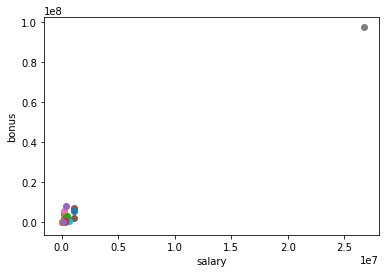

In [1318]:
import matplotlib.pyplot as plt
features = ['salary', 'bonus']
data = featureFormat(data_dict, features,sort_keys = True)
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter(salary,bonus)
plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()


Clearly there is one outlier whic has a massive difference from the rest of the dataset.
Now finding out the outlier:

In [1319]:
r_data = pd.DataFrame(data_dict).loc['salary']
s_data = pd.DataFrame(r_data)
s_data['salary'] = s_data['salary'].astype('float64')
s_data.idxmax(axis = 0)

salary    TOTAL
dtype: object

The outlier is "TOTAL". Clearly this can be ignored when we are trying to find the poi. Also there is "THE TRAVEL AGENCY IN THE PARK" which is not a person. Hence we remove these two from the data_dict.

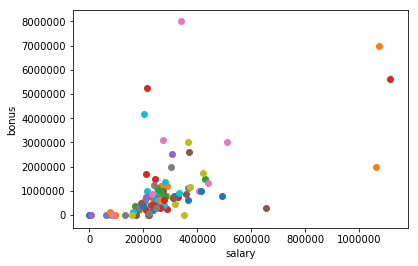

In [1320]:
data_dict.pop('TOTAL',0)
data_dict.pop('THE TRAVEL AGENCY IN THE PARK',0)
data = featureFormat(data_dict, features)
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

#### Combining four features to derive new features , "fraction_to_poi" and "fraction_from_poi"

In [1321]:
def computeFraction(poi_messages,all_messages):
    if poi_messages != 'NaN' or all_messages != 'NaN':
        fraction = float(poi_messages)/float(all_messages)
    else:
        fraction = 0
    return fraction

In [1322]:
for name in data_dict:
    data_point = data_dict[name]
    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction(from_poi_to_this_person,to_messages)
    
    data_point["fraction_from_poi"] = fraction_from_poi
    
    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction(from_this_person_to_poi,from_messages)
    
    data_point["fraction_to_poi"] = fraction_to_poi


Checking the new features

In [1323]:
all_features = []
c = 0
for key in data_dict:
    if c < 1:
        for feature in data_dict[key]:
            all_features.append(feature)
        c += 1
all_features

['to_messages',
 'deferral_payments',
 'expenses',
 'poi',
 'deferred_income',
 'email_address',
 'long_term_incentive',
 'fraction_from_poi',
 'restricted_stock_deferred',
 'shared_receipt_with_poi',
 'loan_advances',
 'from_messages',
 'other',
 'director_fees',
 'bonus',
 'total_stock_value',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'restricted_stock',
 'salary',
 'total_payments',
 'fraction_to_poi',
 'exercised_stock_options']

#### Removal of Some Features

Because of the new feautures above, it only makes sense to remove the features used to come up with the new features. "email_address" is removed because it will not give a numeric data type that can be used to create the numpy arrays for the analysis. "poi" is removed for the moment because it needs to be the first element in the list as indicated in the function used to create the numpy arrays (featureFormat).

In [1324]:
features_remove = ["poi","email_address","from_poi_to_this_person","from_this_person_to_poi","from_messages","to_messages"]

In [1325]:
features_list = ["poi"]
for feature in all_features:
    if feature not in features_remove:
        features_list.append(feature)
print "feature_list = {}".format(feature_list)

feature_list = ['deferral_payments', 'deferred_income', 'from_this_person_to_poi', 'loan_advances', 'from_messages', 'exercised_stock_options', 'restricted_stock_deferred', 'total_stock_value', 'director_fees', 'expenses', 'from_poi_to_this_person', 'poi', 'long_term_incentive', 'to_messages', 'salary', 'bonus']



#### Extracting features and labels from dataset for local testing

In [1326]:
my_dataset = data_dict
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [1327]:
len(features)

143

# EXPLORING CLASSIFIERS


Exploring a variety of classifiers
Here, I explore various classifiers by looping over them and collecting scores for each classfier in a dictionary.

But before this can be done, the data is split into training and testing sets. As hinted in the provided tester.py, splitting the data is done using StratifiedShuffleSplit to account for the fact that the number of one class (i.e. POI) is a lot lower than the other (non-POI).

#### Splitting the features to test and train, converting to numpy arrays

In [1328]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
features = np.array(features)
labels = np.array(labels)
cv = StratifiedShuffleSplit(n_splits=1000, random_state=42)
for train_idx, test_idx in cv.split(features, labels):
    features_train, features_test = features[train_idx], features[test_idx]
    labels_train, labels_test = labels[train_idx], labels[test_idx]

In [1329]:
len(features_train)

128

In [1330]:
len(labels_train)

128

In [1331]:
len(features_test)

15

In [1332]:
len(labels_test)

15

#### Importing modules

In [1355]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold

#### Min max Scaler

In [1334]:
min_max_scaler = MinMaxScaler()
features_train_minmax = min_max_scaler.fit_transform(features_train)
features_test_minmax = min_max_scaler.fit_transform(features_test)

#### Feature Selection using SelectKBest

In [1335]:
select = SelectKBest()
select.fit(features_train_minmax, labels_train)
features_train_minmax_skb = select.transform(features_train_minmax)
features_test_minmax_skb = select.transform(features_test_minmax)

In [1336]:
select.scores_

array([2.59376641e-01, 5.90622308e+00, 5.30405932e+00, 2.61127433e+00,
       2.34933761e+00, 7.63457106e-01, 5.49532138e+00, 1.97148818e-01,
       1.41634132e-02, 1.79642788e+00, 1.11294792e+01, 1.46913087e+01,
       6.57694908e+00, 1.11962683e+01, 2.76789863e+00, 8.24301644e+00,
       1.37140213e+01])

In [1337]:
select.pvalues_

array([6.11439506e-01, 1.64961277e-02, 2.29147970e-02, 1.08607636e-01,
       1.27843297e-01, 3.83911066e-01, 2.06317493e-02, 6.57793758e-01,
       9.05456857e-01, 1.82556762e-01, 1.11679789e-03, 1.98889612e-04,
       1.15039240e-02, 1.08049888e-03, 9.86575829e-02, 4.80039891e-03,
       3.17085391e-04])

In [1338]:
features_list

['poi',
 'deferral_payments',
 'expenses',
 'deferred_income',
 'long_term_incentive',
 'fraction_from_poi',
 'restricted_stock_deferred',
 'shared_receipt_with_poi',
 'loan_advances',
 'other',
 'director_fees',
 'bonus',
 'total_stock_value',
 'restricted_stock',
 'salary',
 'total_payments',
 'fraction_to_poi',
 'exercised_stock_options']

In [1339]:
feature_importance = zip(features_list[1:], select.scores_)

In [1340]:
feature_importance

[('deferral_payments', 0.2593766408553279),
 ('expenses', 5.906223078465953),
 ('deferred_income', 5.304059315507999),
 ('long_term_incentive', 2.611274332028505),
 ('fraction_from_poi', 2.3493376092169673),
 ('restricted_stock_deferred', 0.7634571062228317),
 ('shared_receipt_with_poi', 5.495321379933408),
 ('loan_advances', 0.1971488178025035),
 ('other', 0.014163413206360534),
 ('director_fees', 1.796427878003659),
 ('bonus', 11.129479151071294),
 ('total_stock_value', 14.691308652557398),
 ('restricted_stock', 6.576949076762062),
 ('salary', 11.196268305382173),
 ('total_payments', 2.7678986261219913),
 ('fraction_to_poi', 8.243016438259838),
 ('exercised_stock_options', 13.714021288571228)]

#### Classifiers to be explored

In [1341]:
names = ["K Nearest Neigbours", "SVM", "Decision Tree", "AdaBoost","Random Forest"]

In [1342]:
classifiers  = [KNeighborsClassifier(), SVC(kernel = 'rbf',random_state = 42), 
                DecisionTreeClassifier(random_state = 42), AdaBoostClassifier(random_state = 42), 
               RandomForestClassifier(random_state = 42, n_estimators = 20)]

#### Iteration over classifiers

In [1356]:
accuracy = []
confusion_matrices = []
precision_scores = []
recall_scores = []
f1_scores = []
for name,clf in zip(names,classifiers):
    clf.fit(features_train_minmax_skb, labels_train)
    pred = clf.predict(features_test_minmax_skb)
    accuracy.append(accuracy_score(pred,labels_test))
    conf_mat = confusion_matrix(labels_test, pred)
    confusion_matrices.append(conf_mat)
    precisionscore = round(precision_score(labels_test, pred), 3)
    precision_scores.append(precisionscore)
    recallscore = round(recall_score(labels_test, pred), 3)
    recall_scores.append(recallscore)
    fscore = round(f1_score(labels_test,pred),3)
    f1_scores.append(fscore)
    


C:\Users\Pranav\Anaconda3\envs\Udacity\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [1357]:
selectkbest = {}

for name, clf in zip(names, classifiers):
    pipe_skb = Pipeline([("scaler", MinMaxScaler()), ("skb", SelectKBest()), ("clf", clf)])
    pipe_skb.fit(features_train, labels_train)
    
    skb_scores = {}

    score =  round(pipe_skb.score(features_test, labels_test), 3)
    skb_scores["Accuracy score"] = score
    
    pred = pipe_skb.predict(features_test)

    conf_mat = confusion_matrix(labels_test, pred)
    skb_scores["Confusion matrix"] = conf_mat
    
    precisionscore = round(precision_score(labels_test, pred), 3)
    skb_scores["Precision score"] = precisionscore
    
    recallscore = round(recall_score(labels_test, pred), 3)
    skb_scores["Recall score"] = recallscore
    
    fscore = round(f1_score(labels_test,pred),3)
    skb_scores["F1 Score"] = fscore
    
    selectkbest[name] = skb_scores

In [1358]:

pd.DataFrame.from_dict(selectkbest)

,AdaBoost,Decision Tree,K Nearest Neigbours,Random Forest,SVM
Accuracy score,0.933,0.8,0.867,0.933,0.867
Confusion matrix,"[[12, 1], [0, 2]]","[[11, 2], [1, 1]]","[[13, 0], [2, 0]]","[[13, 0], [1, 1]]","[[13, 0], [2, 0]]"
F1 Score,0.8,0.4,0,0.667,0
Precision score,0.667,0.333,0,1,0
Recall score,1,0.5,0,0.5,0


Clearly AdaBoost gives the best results between accuracy, precision score, recall score and f1 score

### Optimizing the AdaBoost Algorithm

Now the AdaBoostClassifier needs to be optimized to give the best results

In [1346]:
pipe = make_pipeline(MinMaxScaler(), SelectKBest(), AdaBoostClassifier(random_state=42))
print "Pipe steps: \n{}".format(pipe.steps)

Pipe steps: 
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x000000001F91B2E8>)), ('adaboostclassifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42))]


In [1360]:

param_grid = {'selectkbest__k': range(5,15),
    'adaboostclassifier__n_estimators': [5, 10, 20, 30, 40, 50]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

In [1361]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(features_train, labels_train)

C:\Users\Pranav\Anaconda3\envs\Udacity\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x000000001F91B2E8>)), ('adaboostclassifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'adaboostclassifier__n_estimators': [5, 10, 20, 30, 40, 50], 'selectkbest__k': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [1365]:
print "Test score: {:.2f}".format(grid.score(features_test, labels_test))
print "Best cross-validation accuracy: {:.2f}".format(grid.best_score_)
print "Best parameters: {}".format(grid.best_params_)
pred = grid.best_estimator_.predict(features_test)
print "Confusion matrix: \n{}".format(confusion_matrix(labels_test, pred))
print "Recall score: {:.2f}".format(recall_score(labels_test, pred))
print "Precision score: {:.2f}".format(precision_score(labels_test, pred))
print "F1_score: {:.2f}".format(f1_score(labels_test,pred))

Test score: 0.93
Best cross-validation accuracy: 0.88
Best parameters: {'selectkbest__k': 14, 'adaboostclassifier__n_estimators': 10}
Confusion matrix: 
[[12  1]
 [ 0  2]]
Recall score: 1.00
Precision score: 0.67
F1_score: 0.80


In [1366]:
clf = grid.best_estimator_
print clf

Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectkbest', SelectKBest(k=14, score_func=<function f_classif at 0x000000001F91B2E8>)), ('adaboostclassifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=10, random_state=42))])


#### Dumping the classifier, data_dict and features used into pickle files for tester code

In [1367]:
pickle.dump(clf, open("my_classifier.pkl", "w") )
pickle.dump(data_dict, open("my_dataset.pkl", "w") )
pickle.dump(features_list, open("my_feature_list.pkl", "w") )